In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import sem

In [144]:
data = pd.read_csv('data/Default.csv').drop(columns='Unnamed: 0')
data

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879
...,...,...,...,...
9995,No,No,711.555020,52992.378914
9996,No,No,757.962918,19660.721768
9997,No,No,845.411989,58636.156984
9998,No,No,1569.009053,36669.112365


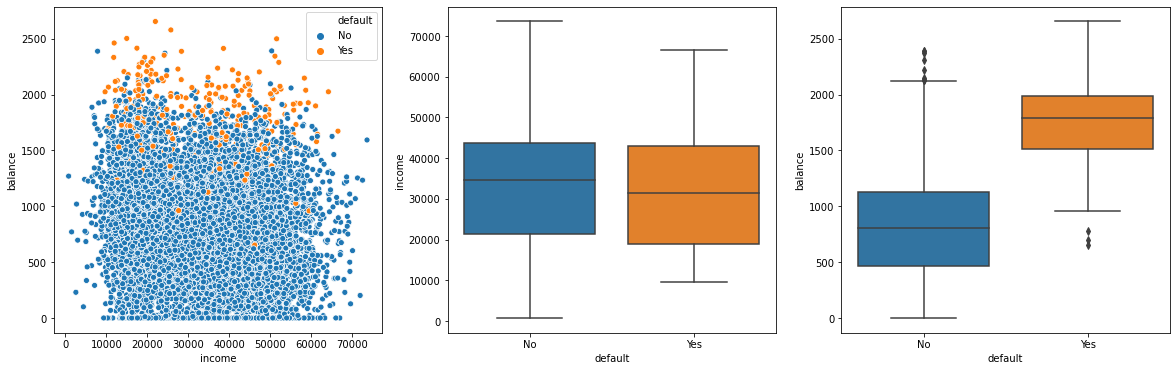

In [145]:
plt.figure(figsize=(20,6))

plot_1 = plt.subplot(1,3,1)
sb.scatterplot(data=data, x='income', y='balance', hue='default')

plot_2 = plt.subplot(1,3,2)
sb.boxplot(data=data, x='default', y='income')

plot_3 = plt.subplot(1,3,3)
sb.boxplot(data=data, x='default', y='balance')

plt.show()

In [146]:
X = data[['income', 'balance']]
y = data['default']

In [148]:
# Build model with class output is Default['No'], prob x >0.5, return 1 mean No Default 
lm = smf.glm(formula='default ~ income + balance', data=data, family=sm.families.Binomial()).fit()
lm_pred = ['No' if x >= 0.5 else 'Yes' for x in lm.predict()]
print('Beta_0: {:.2f}, \t Beta_income: {:.5f}, \t Beta_income: {:.5f}'.format(lm.params[0], lm.params[1], lm.params[2]))
print('Training error: %.4f' %(1-np.mean(lpam_pred==y)))

Beta_0: 11.54, 	 Beta_income: -0.00002, 	 Beta_income: -0.00565
Training error: 0.0263


In [149]:
# Perform Validation set approach
n = data.shape[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
lm = LogisticRegression().fit(X_train, y_train)
lm_pred = lm.predict(X_test)
print('Beta_0: {:.2f}, \t Beta_income: {:.5f}, \t Beta_income: {:.5f}'.format(lm.intercept_[0], lm.coef_[0][0], lm.coef_[0][1]))
print('Test error: %.4f' %(1-np.mean(lm_pred==y_test)))

Beta_0: -11.80, 	 Beta_income: 0.00002, 	 Beta_income: 0.00579
Test error: 0.0250


In [150]:
# Perform Validation set approach multiple time and take average
def result_validation_approach(X, y, n):
    test_error = []
    beta = pd.DataFrame(columns=['Intercept', 'Beta_income', 'Beta_balance'])
    for i in range(n):
        data_train, data_test = train_test_split(data, train_size=0.7, shuffle=True)
        lm = smf.glm(formula='default ~ income + balance', data=data_train, family=sm.families.Binomial()).fit()
        lm_pred = ['No' if x >= 0.5 else 'Yes' for x in lm.predict(data_test)]
        error = 1-np.mean(lm_pred==data_test['default'])
        test_error.append(error)
        beta = beta.append({'Intercept': lm.params[0], 'Beta_income': lm.params[1], 'Beta_balance': lm.params[2]}, ignore_index=True)
    print('Mean test error: %.4f' %np.mean(test_error))
    print('Std of test error: %.4f' %np.std(test_error))
    print('Beta_0: {:.5f}, \t Beta_income: {:.5f}, \t Beta_income: {:.5f}'.format(beta['Intercept'].mean(), beta['Beta_income'].mean(), beta['Beta_balance'].mean()))

In [151]:
result_validation_approach(X, y, 30)

Mean test error: 0.0260
Std of test error: 0.0024
Beta_0: 11.55118, 	 Beta_income: -0.00002, 	 Beta_income: -0.00566


In [152]:
result_validation_approach(X, y, 100)

Mean test error: 0.0265
Std of test error: 0.0025
Beta_0: 11.53706, 	 Beta_income: -0.00002, 	 Beta_income: -0.00564


In [153]:
# Perform Bootstrap to find standard error of coef income and balance
def result_bootstrap(data, n):    
    beta = pd.DataFrame(columns=['Intercept', 'Beta_income', 'Beta_balance'])
    for i in range(100):
        bstrap_sample = data.sample(frac=1, replace=True)
        lm = smf.glm(formula='default ~ income + balance', data=bstrap_sample, family=sm.families.Binomial()).fit()
        beta = beta.append({'Intercept': lm.params[0], 'Beta_income': lm.params[1], 'Beta_balance': lm.params[2]}, ignore_index=True)
    print('By Bootstrap, Coef \t Intercept: {:.4f}, \t Beta_income: {:.10f}, \t Beta_balance: {:.10f}'.format(beta['Intercept'].mean(), beta['Beta_income'].mean(), beta['Beta_balance'].mean()))
    print('Standard error for \t Intercept: {:.4f}, \t Beta_income: {:.10f}, \t Beta_balance: {:.10f}'.format(np.std(beta['Intercept'], ddof=1), np.std(beta['Beta_income'], ddof=1), np.std(beta['Beta_balance'], ddof=1)))

In [157]:
result_bootstrap(data, 1000)

By Bootstrap, Coef 	 Intercept: 11.6139, 	 Beta_income: -0.0000209952, 	 Beta_balance: -0.0056804281
Standard error for 	 Intercept: 0.4178, 	 Beta_income: 0.0000049698, 	 Beta_balance: 0.0002032916


In [158]:
sm_model = smf.glm(formula='default ~ income + balance', data=data, family=sm.families.Binomial()).fit()
print(sm_model.summary())

                        Generalized Linear Model Regression Results                        
Dep. Variable:     ['default[No]', 'default[Yes]']   No. Observations:                10000
Model:                                         GLM   Df Residuals:                     9997
Model Family:                             Binomial   Df Model:                            2
Link Function:                               logit   Scale:                          1.0000
Method:                                       IRLS   Log-Likelihood:                -789.48
Date:                             Sun, 11 Oct 2020   Deviance:                       1579.0
Time:                                     16:01:38   Pearson chi2:                 6.95e+03
No. Iterations:                                  9                                         
Covariance Type:                         nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-

In [159]:
# Compare coef and std err by statsmodel and bootstrap method, it closely same